In [1]:
import math
import subprocess, shlex

import matplotlib
import numpy
from matplotlib import pyplot
%matplotlib inline

import lalsimulation, lal
from lalinference.rapid_pe import lalsimutils

## Bayes' Law and How we Calculate the Posterior

Bayes' law in the context of GW parameter estimation is the following

$$
p(\mu|d) \propto p(\mu) \Lambda(d,\mu)
$$

Where $p(\mu|d)$ is the posterior of the parameter set $(\mu)$ given data $d$, $p(\mu)$ is the prior on said set, and $\Lambda(d,\mu)$ is the likelihood ratio of obtaining the data given a set of parameters $\mu$. In words, the prior is your belief, the likelihood ratio is what the data tells you, and the posterior is your inference based on those two terms. The proportion is because we've neglected the normalization factor which is traditionally not directly calculated by Markovian samplers. It's also not important for this discussion.

### The likelihood ratio

The likelihood ratio is composed of two parts, we express them in the logarithm:

$$
\ln\Lambda(d,\mu) \propto \left(h(\mu)|d\right) - 1/2 \left(h(\mu)|h(\mu)\right)
$$

Where the inner product $\left(a|b\right)$, suggestive of quantum mechanical bra-ket notation is defined as follows:

$$
\left(a|b\right) = 2 \int_{-\infty}^{\infty} \frac{\tilde{a}^{\star} \tilde{b}}{S(f)} df
$$

It is a noise-weighted (the noise weighting is the inverse power spectral density $S(f)$) frequency-domain inner product between two (normally Hermitian symmetric) complex series: the Fourier transform of two (typically real) functions. In the case above, it's the FT of the data time series $d(t)$ and the time domain waveform $h(t)$. For reference, the continuous forward Fourier transform is defined as:

$$
\tilde{a}(f) = \int_{-\infty}^{\infty}a(t) \exp(-2\pi\imath tf) dt
$$

The inverse uses $\tilde{a}(f)\leftrightarrow a(t)$, changes $dt$ for $df$ and $-\imath \rightarrow \imath$, along with a normalization of $\frac{1}{2\pi}$.

The basic concept is that the Fourier transform expresses the function in domains which are dual: the time domain and the frequency domain. You can think of this as two representations of the same function --- just using different bases. The analogy is to a vector --- a vector can be expressed in any (complete) basis, which preserves its magnitude and phase. Those quantities are the invariants, and the Fourier transform expresses a function in two different bases but preserves its overall squared-norm.

Since we work primarily with real functions in the time domain, the corresponding FT is Hermitian symmetric in the frequency domain, and the property is often exploted to turn full intervals into half, starting at zero, positive frequency only intervals.

### Discrete Fourier Transforms

In practice, we use a numerical algorithm to approximate the continuous Fourier transform as a discrete summation. Without going into the details of how it's accomplished, the continuous functions $h(t)$ and $d(t)$ are now considered to be discretely sampled at a regular interval $\Delta t$. We approximate the continuous and infinite frequency-domain interval to be discretely sampled at set of frequencies with interval $\Delta f$. There is a [theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) which says that a function can be completely reconstructed from its FT if it contains no frequency components which lie outside of the interval of integration in the transform, so it is safe to restrict the integral interval to only over up to a given frequency at which we know _a priori_ that no additional content is present. The frequency limit is called the _Nyquist frequency_. A frequency higher than the Nyquist frequency is allowable (does not cause any distortion in the transform) but a lower one will cause _aliasing_. I won't discuss those effects for now, since they aren't relevant. So, we have four numbers which desribe the "perimeter" and "sampling" of the time/frequency series in either domain:

  * $\Delta t$ -- discrete sampling interval between time domain samples and the inverse of the sampling rate.
  * $\Delta f$ -- discrete sampling interval between frequency domain samples
  * $T$ -- the length of the time series $N\times\Delta t$
  * $f_N$ -- the Nyquist frequency $N\times\Delta f$

So, we (without any further motivation) rerwite the continuous FT into a discrete FT:

$$
\tilde{a}_k = \sum_{j}^{N} a_j \exp\left(\frac{-2\pi\imath jk}{N}\right)
$$

So, the integral over $t$ has changed to a sum (over $N$ samples) over a discrete index $j$, with frequency index $k$. In practice, this algorithm can be made efficient in several ways, and typically is executed with $\sim N\text{log}N$ operations. Let's translate this to the likelihood.


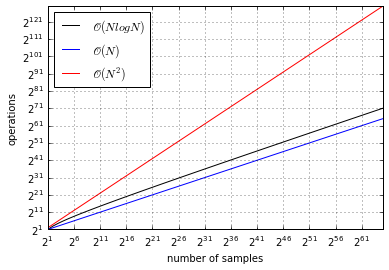

In [2]:
n = numpy.logspace(1, 65, num=64, base=2)
ops = [math.log(ni, 2)*ni for ni in n]
pyplot.plot(n, ops, 'k-', label='$\mathscr{O}(NlogN)$')
pyplot.plot(n, n, 'b-', label='$\mathscr{O}(N)$')
pyplot.plot(n, n**2, 'r-', label='$\mathscr{O}(N^2)$')
pyplot.loglog(basex=2, basey=2)
pyplot.grid()
pyplot.xlabel("number of samples")
pyplot.ylabel("operations")
pyplot.legend(loc="upper left");

### Discrete Fourier Transform

We intend to do two inner products, one for $d$ with $h$ and one for $h$ with itself. These are in the frequency domain, so the data must be transformed from the time domain, or generated natively in the frequency domain. However, to calculate the log likelihood, it is a multiplication of $N$ samples and then a sum over $N$ samples for the result of the multipltication. However, let's break down the $N$, since this might end up dominating our cost.

#### The cost of generating one likelihood sample

The cost of generating one sample depends on the waveform itself, as well as its native domain represenation. Ignoring for now the cost of generating the waveform, look first at the number of samples to work with. It's obvious from the relations above that, in the time domain, the number of samples needed is straightfoward: for a signal of length $T$ and sampling distance $\Delta t$, the number of samples is the product. For example, an 8 second long time series sampled at 16384 Hz (or $\Delta t = 6.1\times10^{-5}$ s) requires 131072 samples. What may not be obvious from the relations above is the representable frequency domain signal, but notice that $N$ can be defined for both the frequency and the time domain independently. If you set them equal, you'll be able to transfer between the two. Another point to observe is that $T$ sets the scale for the frequency spacing. There is a simple (but not rigorous) heuristical argument. In the continous case, the longest wavelength which is resolvable with a function of interval $T$ is $1/T$. That's equivalent to drawing a half a wavelength with zeroes between the end point of a line segment of length $T$. Intrinsically, this is an expression of the uncertainty principle: you can't construct information about long wavelength frequency content without having a long enough period in time to measure those frequencies.

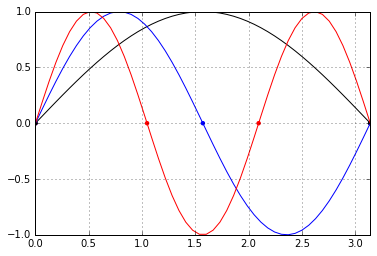

In [3]:
x = numpy.linspace(0, numpy.pi)
y = numpy.sin(x)
pyplot.plot(x, y, 'k-')

x = numpy.linspace(0, numpy.pi)
y = numpy.sin(2*x)
pyplot.plot(x, y, 'b-')

x = numpy.linspace(0, numpy.pi)
y = numpy.sin(3*x)
pyplot.plot(x, y, 'r-')

pyplot.scatter([0, numpy.pi/3, 2*numpy.pi/3, numpy.pi], [0, 0, 0, 0], color='r', edgecolor='none')
pyplot.scatter([0, numpy.pi/2, numpy.pi], [0, 0, 0], color='b', edgecolor='none')
pyplot.scatter([0, numpy.pi], [0, 0], color='k', edgecolor='none')

pyplot.xlim(0, numpy.pi)
pyplot.ylim(-1, 1)
pyplot.grid()

So, the smallest resolvable frequency difference in a discrete transform --- and hence $\Delta f$ is set by $T$: $\Delta f=\frac{1}{T}$. Knowing these two facts, you can infer the following frequency information from a time series:

  * The frequency resolution: $\Delta f = \frac{1}{T}$
  * The Nyquist frequency $f_N = \frac{1}{2\Delta t}$

In the MCMC, you have two handles on these settings: `~~seglen` and `--sample-rate`, which correspond to $T$ and $\Delta t$ respectively. Let's use an example value of `--seglen 32` and `--samples-rate 4096`. These are fairly typical settings for `lalinference_mcmc` with BNS systems of ~2015 era aLIGO. Using these numbers, it's clear the that the number of samples the product of the two. Increasing the seglen or samples rate increases $N$ by those factors, and hence the log likelihood operations mentioned above.

### How the expected waveform brackets our calculation

"So," you say, "...why not just set this as small/large as possible so we don't have to do so many calculations." The answer is, as always, _physics_! Recall I said that a function could be reconstructed if you have all the right frequency components up to the point where the contribution to the transform is zero above $f_N$. So, we have to determine the bounds on this for a given $h(\mu)$.

The physics are as follows. To zeroth (Newtonian) order, the time/frequency evolution is constrained and monotonic. From Maggiore (2008):

$$
\tau \propto \frac{1}{M_c}^{5/8} \frac{1}{f_{\text{GW}}}^{3/8}
$$

Where I've omitted some constants and prefactors, and $\tau$ is the time to coalescence, and $M_c$ is the chirp mass. This formula is singular at $f_{\text{GW}}=0$ which represents the binary at infinite separation. However, we're only concerned with the binary at very close separation, at late inspiral. This formula tells us (approximately) how low we have until coalescence we have if we measure the binary at a given orbital (half the GW) frequency. It also tells us that its proportional to the chirp mass, which means heavier systems will inspiral more quickly from a given starting frequency.

This is the formula that gives us a handle on $T$, but we have to give it a frequency. We resort to noting that, for astrophysical binaries, that the signal from the earlier inspiral is indistinguishable from our noise at a given point where the noise spectrum becomes very high relative to the expected strength of the wave. For initial LIGO (2005-2010) this was 40 Hz. For 2015 era (present of this writing), it's about 35-30. For full design sensitivity advanced LIGO, it's expected to be 10 Hz. Fixing the chirp mass, the ratio of two times-two-coalesces grows as the ratio of starting frequencies to the $-3/8$ power.

In [4]:
# Example: between 40 -> 10 Hz:
(40./10)**(8./3)

40.317473596635935

So for initial to advanced LIGO, the waveforms stay "in band" or in our envelope of sensitivity for 40 times longer! There is a program called `lalapps_chirplen` which does a more accurate calculation and allows you to give different low frequencies.

In [5]:
for f in (40, 30, 20, 10):
    proc = subprocess.Popen(shlex.split("lalapps_chirplen --flow %d --m1 1.4 --m2 1.4" % f), stdout=subprocess.PIPE)
    print proc.communicate()[0]

fStart according to Tev = 3.999999e+01 Hz
fStop  according to Tev = 1.568027e+03 Hz
length according to Tev = 2.542906e+01 seconds
Ncycle according to Tev = 1621.794584 

fStart according to Tev = 2.999998e+01 Hz
fStop  according to Tev = 1.527384e+03 Hz
length according to Tev = 5.467890e+01 seconds
Ncycle according to Tev = 2620.036974 

fStart according to Tev = 1.999983e+01 Hz
fStop  according to Tev = 1.513428e+03 Hz
length according to Tev = 1.607861e+02 seconds
Ncycle according to Tev = 5144.283297 

fStart according to Tev = 9.999962e+00 Hz
fStop  according to Tev = 1.483781e+03 Hz
length according to Tev = 1.016169e+03 seconds
Ncycle according to Tev = 16274.463984 



So, from 40 Hz, a 1.4+1.4 solar mass binary goes from 25 seconds to 1000 seconds! At the same sampling rate, we're talking about 40x more samples to process. This progression towards lower frequencies indicates that we have to __increase__ the `--seglen` to compensate for lowering the `--flow` argument. Since we typically do things in powers of two, we usually round up. That means that last one (at 10 Hz) just barely fits in `--seglen 1024` ... and that's for 1.4+1.4. It gets worse:

In [6]:
proc = subprocess.Popen(shlex.split("lalapps_chirplen --flow 10 --m1 1.0 --m2 1.0"), stdout=subprocess.PIPE)
print proc.communicate()[0]

fStart according to Tev = 1.000002e+01 Hz
fStop  according to Tev = 2.010576e+03 Hz
length according to Tev = 1.776725e+03 seconds
Ncycle according to Tev = 28459.887649 



That's `--seglen 2048` for the lowest typical mas binary we look for. Ouch. By the way, we don't push the low frequency down simply because "we can". The more of the inspiral we capture at lower frequencies, the more signal-to-noise ratio we accumulate (though this effect is usually not great), *and* the better we measure some parameters (like chirp mass).

Okay, we've got the length of one side and one corner, now we need the opposing corner. This comes from either the "inner most stable orbit" (ISCO) or the ringdown frequency. For approximants that have "Taylor" in the same, it's a good bet that no merger or ringdown are included, so ISCO is appropriate. The above program lists ISCO (approximately) as "fStop". As an example, the 1.4+1.4 starts to merge near 1484 Hz. Of course, we expect that there will be power in frequencies above this for the merger and ringdown, but for BNS, this probably isn't recognizeable in the noise, and in practice adds little to the discerning power of the calculation. However, we still tend to work in powers of two, so this gives us `--sample-rate 4096` (remember the nyuist frequency is __one half__ of the sampling rate, so adjust accordingly). You should give yourself a small buffer above the ISCO of the lowest mass binary that you intend to use. This means if you use the default settings of `--comp-min 1`, then the relevant command:

In [7]:
proc = subprocess.Popen(shlex.split("lalapps_chirplen --flow 30 --m1 1.0 --m2 1.0"), stdout=subprocess.PIPE)
print proc.communicate()[0]

fStart according to Tev = 3.000008e+01 Hz
fStop  according to Tev = 2.043901e+03 Hz
length according to Tev = 9.558946e+01 seconds
Ncycle according to Tev = 4586.439190 



For 2015 (O1 era) aLIGO, you need `--seglen 128` to contain the lowest mass, equal-mass binary. The ISCO is about 2049, so you need to go to `--sample-rate 4096`, and even then you're probably cutting off a little bit (in this case, it may be permissable). So, there it is:

  * For a search including a 1.0 + 1.0 solar mass binary:
    * Frequency boundaries: (30-2048), implying a $\Delta t$ of 1/4096
    * Time boundaries $\max T = 128$ implying a frequency discretization in $\Delta f \sim 1/128$

You can now see how tweaking each of the parameters causes the calculation to get more and more expensive. Going to lower mass means longer waveforms and higher frequencies.

### Considerations in Generating a Waveform

We've neglected this, but it can (and in many cases does) dominate the actual cost of doing inference. I'll broadly classify the waveforms as "analytical post-Newtonian" and "Phenomenological" waveforms. The division is because they are generated from different considerations and generally address different problems.

#### Analytical Post-Newtonian Waveforms

These waveforms, the most familiar being the TaylorT{1,2,3,4,5} and spinning SpinTaylorT{1,2,3,4,5} variants are time-domain waveforms generated by evolving the equations of motion of the binary up to a give post-Newtonian ($(v/c)^2$) order, and extracting the radiation with various approximations of the flux or orbital dynamics. The details are a rich and very well understood regime of GR, there are many references. Suffice it to say, the approximations break down well before merger, and are not connected to the ringdown in a mathematically rigorous way (you can infer one from the other, but are only connected by the physical parameters of the binary). This means they are suitable for BNS systems where the merger and ringdown have little contribution to your problem. They are evolved analytically and as such are reasonably computationally cheap, among the fastest to use. An added bonus is that they also have Fourier domain variants, e.g. TaylorF2. This is advantageous, because recall we need the waveform $h(\mu)$ in the _frequency_ domain to work with it. In order to use a time domain variant, you need an additional FFT every time you generate a new waveform and that's another $N\text{log}N$ operations on top of everything else you have to do. Fourier domain variants avoid this, and are supposed to emulate the time domain dynamics exactly.

Widely used examples:

  * SpinTaylorT4
  * TaylorF2
  * SpinTaylorF2

#### Phenomenological Waveforms

Since about 2005, numerical relativists have been able to simulate the dynamics of the binary the entire way through merger and ringdown, and have verified and bolstered several phenomenological models of gravitational radiation from the system. Since then, several families of waveforms which include the radiation from merger and ringdown have been developed. They are commonly used in searches for NSBH and BBH, because the merger and spin effects are much more important here.

Their generation, however, is much slower because they either interpolate over a complex signal manifold, or do a very complicated evolution of several quanties which need to be stitiched together and tuned carefully to agree with numerical relativity. To ameliorate this somewhat, a few _reduced order models_ of the waweform families have been produced, which provide accurate representations of the expensive waveforms without the cost. The first few families included no spin, then aligned spin, and the latest set have included almost all of the well understood spin effects of the waveform. Some are time domain and some are frequency domain, and confusingly some are both depending on whether ROM is used. In general, they do not handle BNS cases very well, are usually used in NSBH (when a dominant spin is necessary to describe physics) and BBH (Where the merger is the vast majority of the signal power collected).

Widely used examples:

  * IMRPhenomD (frequency domain, aligned spin)
  * SEOBNRv2 (time domain, aligned spin)
  * SEOBRNv2_ROM_DoubleSpin (frequency domain, ROM model of the previous)
  * IMRPhenomPv2 (frequency domain, precessional and alignes spin dynamics)

It's important to note that when using these models, you should give yourself a __bigger__ buffer above the ISCO. There are calculators for ringdown frequency, but are not as widely available as `lalapps_chirplen`. A factor of 1.2-1.5 is appropriate. In general, this factor is allowable since the ISCO of a higher mass system is lower (because of the chirp mass dependence), so the cost of the buffer is offset by the lower sample rate implied by the mass of the system.

In [8]:
# Comparison of generation times between Taylor approximants and SEOBNRv2

# TaylorF2 is a frequency domain approximant
print "TaylorF2"
%timeit lalsimulation.SimInspiralChooseFDWaveform(0., 1.0/32.0, 10 * lal.MSUN_SI, 10 * lal.MSUN_SI, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30., 2048.0, 31., 1e6 * lal.PC_SI, 0.0, 0.0, 0.0, None, None, 0, 7, lalsimulation.TaylorF2)

# SpinTaylorT2 is a time domain spinning approximant
print "SpinTaylorT2"
%timeit lalsimulation.SimInspiralChooseTDWaveform(0., 1.0/4096, 10 * lal.MSUN_SI, 10 * lal.MSUN_SI, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30., 31., 1e6 * lal.PC_SI, 0.0, 0.0, 0.0, None, None, 0, 7, lalsimulation.SpinTaylorT2)

# SpinTaylorT4 is a time domain spinning approximant
print "SpinTaylorT4"
%timeit lalsimulation.SimInspiralChooseTDWaveform(0., 1.0/4096, 10 * lal.MSUN_SI, 10 * lal.MSUN_SI, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 30., 31., 1e6 * lal.PC_SI, 0.0, 0.0, 0.0, None, None, 0, 7, lalsimulation.SpinTaylorT4)

# SEOBNRv2 is a time domain approximant
print "SEOBNRv2"
%timeit lalsimulation.SimInspiralChooseTDWaveform(0., 1.0/4096, 10 * lal.MSUN_SI, 10 * lal.MSUN_SI, 0.0, 0.0, 0.99, 0.0, 0.0, 0.99, 30., 31., 1e6 * lal.PC_SI, 0.0, 0.0, 0.0, None, None, 0, 7, lalsimulation.SEOBNRv2)

# SEOBNRv3 is a time domain approximant
print "SEOBNRv3"
%timeit lalsimulation.SimInspiralChooseTDWaveform(0., 1.0/4096, 10 * lal.MSUN_SI, 10 * lal.MSUN_SI, 0.0, 0.0, 0.99, 0.0, 0.0, 0.99, 30., 31., 1e6 * lal.PC_SI, 0.0, 0.0, 0.0, None, None, 0, 7, lalsimulation.SEOBNRv3)

# Note that this comparison is kinda unfair. There are ROM models for SEOBNRv2 which are used
# almost exclusively and are comparable to TaylorF2. But feel free to put in your own favorite
# model and see.

TaylorF2
100 loops, best of 3: 9.43 ms per loop
SpinTaylorT2
100 loops, best of 3: 7.26 ms per loop
SpinTaylorT4
100 loops, best of 3: 5.18 ms per loop
SEOBNRv2
1 loops, best of 3: 1.06 s per loop
SEOBNRv3
1 loops, best of 3: 1.42 s per loop


### Mock likelihood calculation

In [9]:
# fake noise realization: the actual shape doesn't matter
seglen = 32.0
delta_f = 1.0 / seglen
fmax = 2048
noise = numpy.ones(shape=fmax/delta_f+1)
print noise.shape

(65537,)


In [10]:
def loglikelihood(approx, flow=20, df=0.125, fmax=2048):
    hpt, hxt = lalsimulation.SimInspiralFD(0., df,
                                       10 * lal.MSUN_SI, 10 * lal.MSUN_SI,
                                       0.0, 0.0, 0.99, 0.0, 0.0, 0.99,
                                       flow, fmax, 31.,
                                       1e6 * lal.PC_SI, 0.0, 0.0, 0.0, 0.0,
                                       None, None, 0, 7, approx)

    #hpt.data.data += hxt.data.data

    # Multiply waveform by its complex conjugate and divide by our "noise realization"
    # FIXME: The second term is actually another multiply the data itself (presumably pre whitened)
    # with the wavform... We'll mock it with the waveform with itself --- the computational speed
    # should be the same
    numpy.sum(hpt.data.data.conj() * hpt.data.data / noise - 0.5 * hpt.data.data.conj() * hpt.data.data)

%timeit loglikelihood(lalsimulation.SpinTaylorT2, df=delta_f)

10 loops, best of 3: 40.4 ms per loop


### Phenomenological Waveforms, Spin and Distance

All of the previous time-frequency transform considerations do not include the effects of spin. As you've now seen, many of the waveforms employed include spin in _some_ way. The rule of thumb in dealing with how this will affect the size of the waveform is mostly tied to the components of spin aligned along the orbital angular momentum of the binary (the so called aligned-spin). In general, the waveform frequency content and length is shortened or lengthened by which way the spins are aligned. There is some basic physics here. Gravitational-waves carry energy *and* angular momentum away from a system (if the graviton had charge, that too would be carried away). The solution to the static Kerr (spinning BH) metric includes a term which is influenced by the angular momentum of the particle placed along a geodesic in the space. Extrapolating from a point particle to another BH is not easy, but it is easy to infer that the angular momentum of *both* components will matter. In general, the more angular momentum an object has, the longer it can stay in orbit around the BH (it corresponds to horizons which are smaller in area).

That said, this means that if the angular momentum of the component adds to the overall angular momentum of the system, then it will take *longer* for the system to bleed off that angular momentum in GW, and the waveform itself is longer. This configuration means that at least one of the spin vectors $\vec{S}_i$ has a component lying parallel to the orbital angular momentum $\vec{L}$, and the overall angular momentum of the system $\vec{J}=\vec{L}+\sum_i\vec{S}_i$ is higher. The opoosite case has the opposite effect. There are two components that contribute to this, so one can cancel (partially) the other if the two *spins* are anti-parallel. Moreover, the spins are typically normalized by the mass of the component, and so the bigger mass tends to dominate, jerking the smaller mass around and torquing it in the process. There is no hard and fast mathematics to get you to the right answer for how this changes the length of the binary, but you can bet for a maximally spinning set of aligned-spin equal mass, that the waveform will be longer, maybe by a factor of up to 1.5 depending on mass. Take this into account.

1.26568830467
1.25573916927


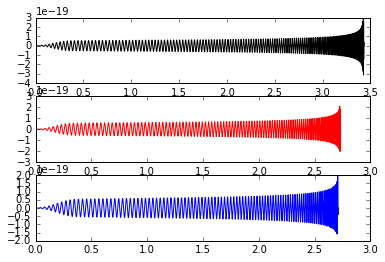

In [11]:
hp_a, hx_a = lalsimulation.SimInspiralTD(
            0, 1.0/4096,
            10 * lal.MSUN_SI, 10 * lal.MSUN_SI,
            0.0, 0.0, 0.99,
            0.0, 0.0, 0.99,
            30., 31.,
            1e6 * lal.PC_SI, 0.0,
            0.0, 0.0, 0.0,
            None, None, 0, 7, lalsimulation.SpinTaylorT4)

hp_z, hx_z = lalsimulation.SimInspiralTD(
            0, 1.0/4096,
            10 * lal.MSUN_SI, 10 * lal.MSUN_SI,
            0.0, 0.0, 0.0,
            0.0, 0.0, 0.0,
            30., 31.,
            1e6 * lal.PC_SI, 0.0,
            0.0, 0.0, 0.0,
            None, None, 0, 7, lalsimulation.SpinTaylorT4)

hp_aa, hx_aa = lalsimulation.SimInspiralTD(
            0, 1.0/4096,
            10 * lal.MSUN_SI, 10 * lal.MSUN_SI,
            0.0, 0.0, -0.99,
            0.0, 0.0, -0.99,
            30., 31.,
            1e6 * lal.PC_SI, 0.0,
            0.0, 0.0, 0.0,
            None, None, 0, 7, lalsimulation.SpinTaylorT4)

t_a, t_z, t_aa = numpy.linspace(0, len(hp_a.data.data)/4096., len(hp_a.data.data)), numpy.linspace(0, len(hp_z.data.data)/4096., len(hp_z.data.data)), numpy.linspace(0, len(hp_aa.data.data)/4096., len(hp_aa.data.data))

pyplot.subplot(3,1,1)
pyplot.plot(t_a, hp_a.data.data+hx_a.data.data, 'k-', label='aligned')
pyplot.subplot(3,1,2)
pyplot.plot(t_z, hp_z.data.data+hx_z.data.data, 'r-', label='zero')
pyplot.subplot(3,1,3)
pyplot.plot(t_aa, hp_aa.data.data+hx_aa.data.data, 'b-', label='anti-aligned')

print float(len(t_a))/len(t_aa)
print float(len(t_a))/len(t_z)

#### Distance

The distance must also be bracketed via the `--distance-max` argument. The default for this is 2 Gpc. This tends to be a huge overestimate for sources like BNS. However, there are many considerations that go into this parameter. The main rule of thumb is the horizon distance. The horizon distance is defined as:

> The distance at which a face-on binary will produce a signal to noise ratio of 8 in a detector which is oriented optimally with respect to its location in the sky.

That is to say, the antenna response is identically unity, and the inclination produces both polarizations in equal and maximal strength. There is an integral formulation (take the inner product of the signal with itself above and fix the angle parameters to match the above definition, set d = 1 Mpc, then renormalize the integral so that it equals $8^2$. That normalization is the inverse (in Mpc) of the horizon distance squared.

$$
F_+(\alpha, \delta, \psi) = F_{\times}(\alpha, \delta, \psi) = 1
$$
$$
h_{\text{ref}} = h_+(d = 1 \text{Mpc},\iota = 0, M_c, \eta) + h_{\times}(d = 1 \text{Mpc}, \iota = 0, M_c, \eta)
$$
$$
d_{H}^2 = \frac{1}{8^2} 4 \int_{0}^{\infty} \frac{\tilde{h}_{\text{ref}}^{\star}\tilde{h}_{\text{ref}}}{S(f)} df
$$

Note that these constraints may be impossible to satisfy for a real network of interferometers. The curvature of the earth basically disallows all antenna patterns to be maximized simultaneously for a given point on the sky, though for *two* widely separated detectors you may be able to use the polarization angle $\psi$ to compensate.

In practice, $h$ is approximated as its frequency domain Newtownian order representation, so you may see $\tilde{h}^{\star}\tilde{h} \rightarrow f^{-7/3}$ with some additional constants and the chirp mass fixed to a 1.4+1.4 binary. This works reasonably well for BNS, but breaks down for NSBH and especially for BBH where other effects like merger and ringdown play a role.

To avoid doing this integral, here is a table (drawn from http://arxiv.org/pdf/1304.0670v1.pdf) with horizon distances from the various epochs of advanced LIGO sensitivity:

| epoch | horizon distance (Mpc) |
| ----- | ---------------------- |
| 2015 | 180 |
| 2016 | 270 |
| 2017 | 384 |
| 2018 (full design sensitivity) | 451 |

Note that this is for a standard 1.4+1.4 binary. The strain scales as $M_c^{5/3}$ power, so apply an appropriate ratio when transforming to a different mass binary. Also note that this is a *single* detector. Adding additional detectors will increase the range (roughly) by a factor of $\sqrt{N}$.

In [12]:
#  For example, a 5+5 solar mass binary, detected by three interferometers in 2018 will have a horizon 
mc1414, _ = lalsimutils.Mceta(1.4, 1.4)
mc55, _ = lalsimutils.Mceta(5.0, 5.0)

mc_factor = (mc55/mc1414)**(5/3)

451 * mc_factor * math.sqrt(3)

2789.838979334156

This calculation ignores cosmological effects. The redshifting effect of an expanding universe both pushes things further away, but also redshifts the masses we measure from their source values. Fro NSBH and lower mass BBH the effects compete to allow us to see "further". For BNS, advanced LIGO does not see far enough to have significant differences from redshift. Full treatments of these effects are cosmology parameter dependent, and typically included in the post processing from the PE samples.